Импорт библиотек

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image
import scipy.stats as stats
%matplotlib inline 
sns.set(style="ticks")

Загрузка датасета

In [33]:
hdata_loaded  = pd.read_csv("netflix_titles_data.csv")
print(hdata_loaded)

     show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water              NaN   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans              NaN   
4         s5  TV Show           Kota Factory              NaN   
...      ...      ...                    ...              ...   
8802   s8803    Movie                 Zodiac    David Fincher   
8803   s8804  TV Show            Zombie Dumb              NaN   
8804   s8805    Movie             Zombieland  Ruben Fleischer   
8805   s8806    Movie                   Zoom     Peter Hewitt   
8806   s8807    Movie                 Zubaan      Mozez Singh   

                                                   cast        country  \
0                                                   NaN  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa 

Устранение пропусков в данных

In [34]:
hdata = hdata_loaded
list(zip(hdata.columns, [i for i in hdata.dtypes]))

[('show_id', dtype('O')),
 ('type', dtype('O')),
 ('title', dtype('O')),
 ('director', dtype('O')),
 ('cast', dtype('O')),
 ('country', dtype('O')),
 ('date_added', dtype('O')),
 ('release_year', dtype('int64')),
 ('rating', dtype('O')),
 ('duration', dtype('O')),
 ('listed_in', dtype('O')),
 ('description', dtype('O'))]

In [35]:
# cols with missing values
hcols_with_na = [c for c in hdata.columns if hdata[c].isnull().sum() > 0]
hcols_with_na

['director', 'cast', 'country', 'date_added', 'rating', 'duration']

In [36]:
# count
[(c, hdata[c].isnull().sum()) for c in hcols_with_na]

[('director', 2634),
 ('cast', 825),
 ('country', 831),
 ('date_added', 10),
 ('rating', 4),
 ('duration', 3)]

In [42]:
# percent
[(c, hdata[c].isnull().mean()) for c in hcols_with_na]

[('director', 0.0),
 ('cast', 0.0),
 ('country', 0.0),
 ('date_added', 0.0),
 ('rating', 0.0),
 ('duration', 0.0)]

Заполнение показателями центра распределения и константой

In [38]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [39]:
all_data, filled_data, missed_data = impute_column(hdata, 'director', 'constant', 'unknown')
all_data, filled_data, missed_data

(array(['Kirsten Johnson', 'unknown', 'Julien Leclercq', ...,
        'Ruben Fleischer', 'Peter Hewitt', 'Mozez Singh'], dtype=object),
 array(['unknown', 'unknown', 'unknown', ..., 'unknown', 'unknown',
        'unknown'], dtype=object),
 array([nan, nan, nan, ..., nan, nan, nan], dtype=object))

In [40]:
hcols_with_na

['director', 'cast', 'country', 'date_added', 'rating', 'duration']

In [41]:
for i in hcols_with_na:
    if i == 'rating' or i == 'duration':
        all_data, filled_data, missed_data = impute_column(hdata, i, 'most_frequent')
    else:
        all_data, filled_data, missed_data = impute_column(hdata, i, 'constant', 'unknown')
    hdata[i] = all_data
hdata.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [44]:
hdata_loaded

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",unknown,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,unknown,unknown,unknown,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,unknown,unknown,unknown,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [46]:
hcols_with_na = [c for c in hdata_loaded.columns if hdata_loaded[c].isnull().sum() > 0]
[(c, hdata_loaded[c].isnull().sum()) for c in hcols_with_na]

[]

In [47]:
res = hdata_loaded.dropna(axis=0, how='any')

In [48]:
hcols_with_na = [c for c in res.columns if res[c].isnull().sum() > 0]
[(c, res[c].isnull().sum()) for c in hcols_with_na]

[]

Кодирование категориальных признаков

In [58]:
res

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,unknown,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",unknown,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,unknown,unknown,unknown,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8803,s8804,TV Show,Zombie Dumb,unknown,unknown,unknown,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [59]:
#  Count encoding предполагает что значение категории заменяется на количество раз, которое оно встречается в категории.
from category_encoders.count import CountEncoder as ce_CountEncoder
ce_CountEncoder1 = ce_CountEncoder()
data_COUNT_ENC = ce_CountEncoder1.fit_transform(res[res.columns.difference(['director'])])
data_COUNT_ENC

,cast,country,date_added,description,duration,listed_in,rating,release_year,show_id,title,type
0,825,2818,1,1,152,359,490,2020,1,1,6131
1,1,30,10,1,425,26,3211,2021,1,1,2676
2,1,831,10,1,1796,18,3211,2021,1,1,2676
3,825,831,10,1,1796,16,3211,2021,1,1,2676
4,1,972,10,1,425,94,3211,2021,1,1,2676
...,...,...,...,...,...,...,...,...,...,...,...
8802,1,2818,30,1,12,1,799,2007,1,1,6131
8803,825,831,52,1,425,4,334,2018,1,1,2676
8804,1,2818,89,1,116,12,799,2009,1,1,6131
8805,1,2818,1,1,116,201,287,2006,1,1,6131


Нормализация числовых признаков

Сохранение для следующей работы

In [62]:
res = data_COUNT_ENC
res

,cast,country,date_added,description,duration,listed_in,rating,release_year,show_id,title,type
0,825,2818,1,1,152,359,490,2020,1,1,6131
1,1,30,10,1,425,26,3211,2021,1,1,2676
2,1,831,10,1,1796,18,3211,2021,1,1,2676
3,825,831,10,1,1796,16,3211,2021,1,1,2676
4,1,972,10,1,425,94,3211,2021,1,1,2676
...,...,...,...,...,...,...,...,...,...,...,...
8802,1,2818,30,1,12,1,799,2007,1,1,6131
8803,825,831,52,1,425,4,334,2018,1,1,2676
8804,1,2818,89,1,116,12,799,2009,1,1,6131
8805,1,2818,1,1,116,201,287,2006,1,1,6131


In [63]:
res.to_csv('lab2.csv')

In [64]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

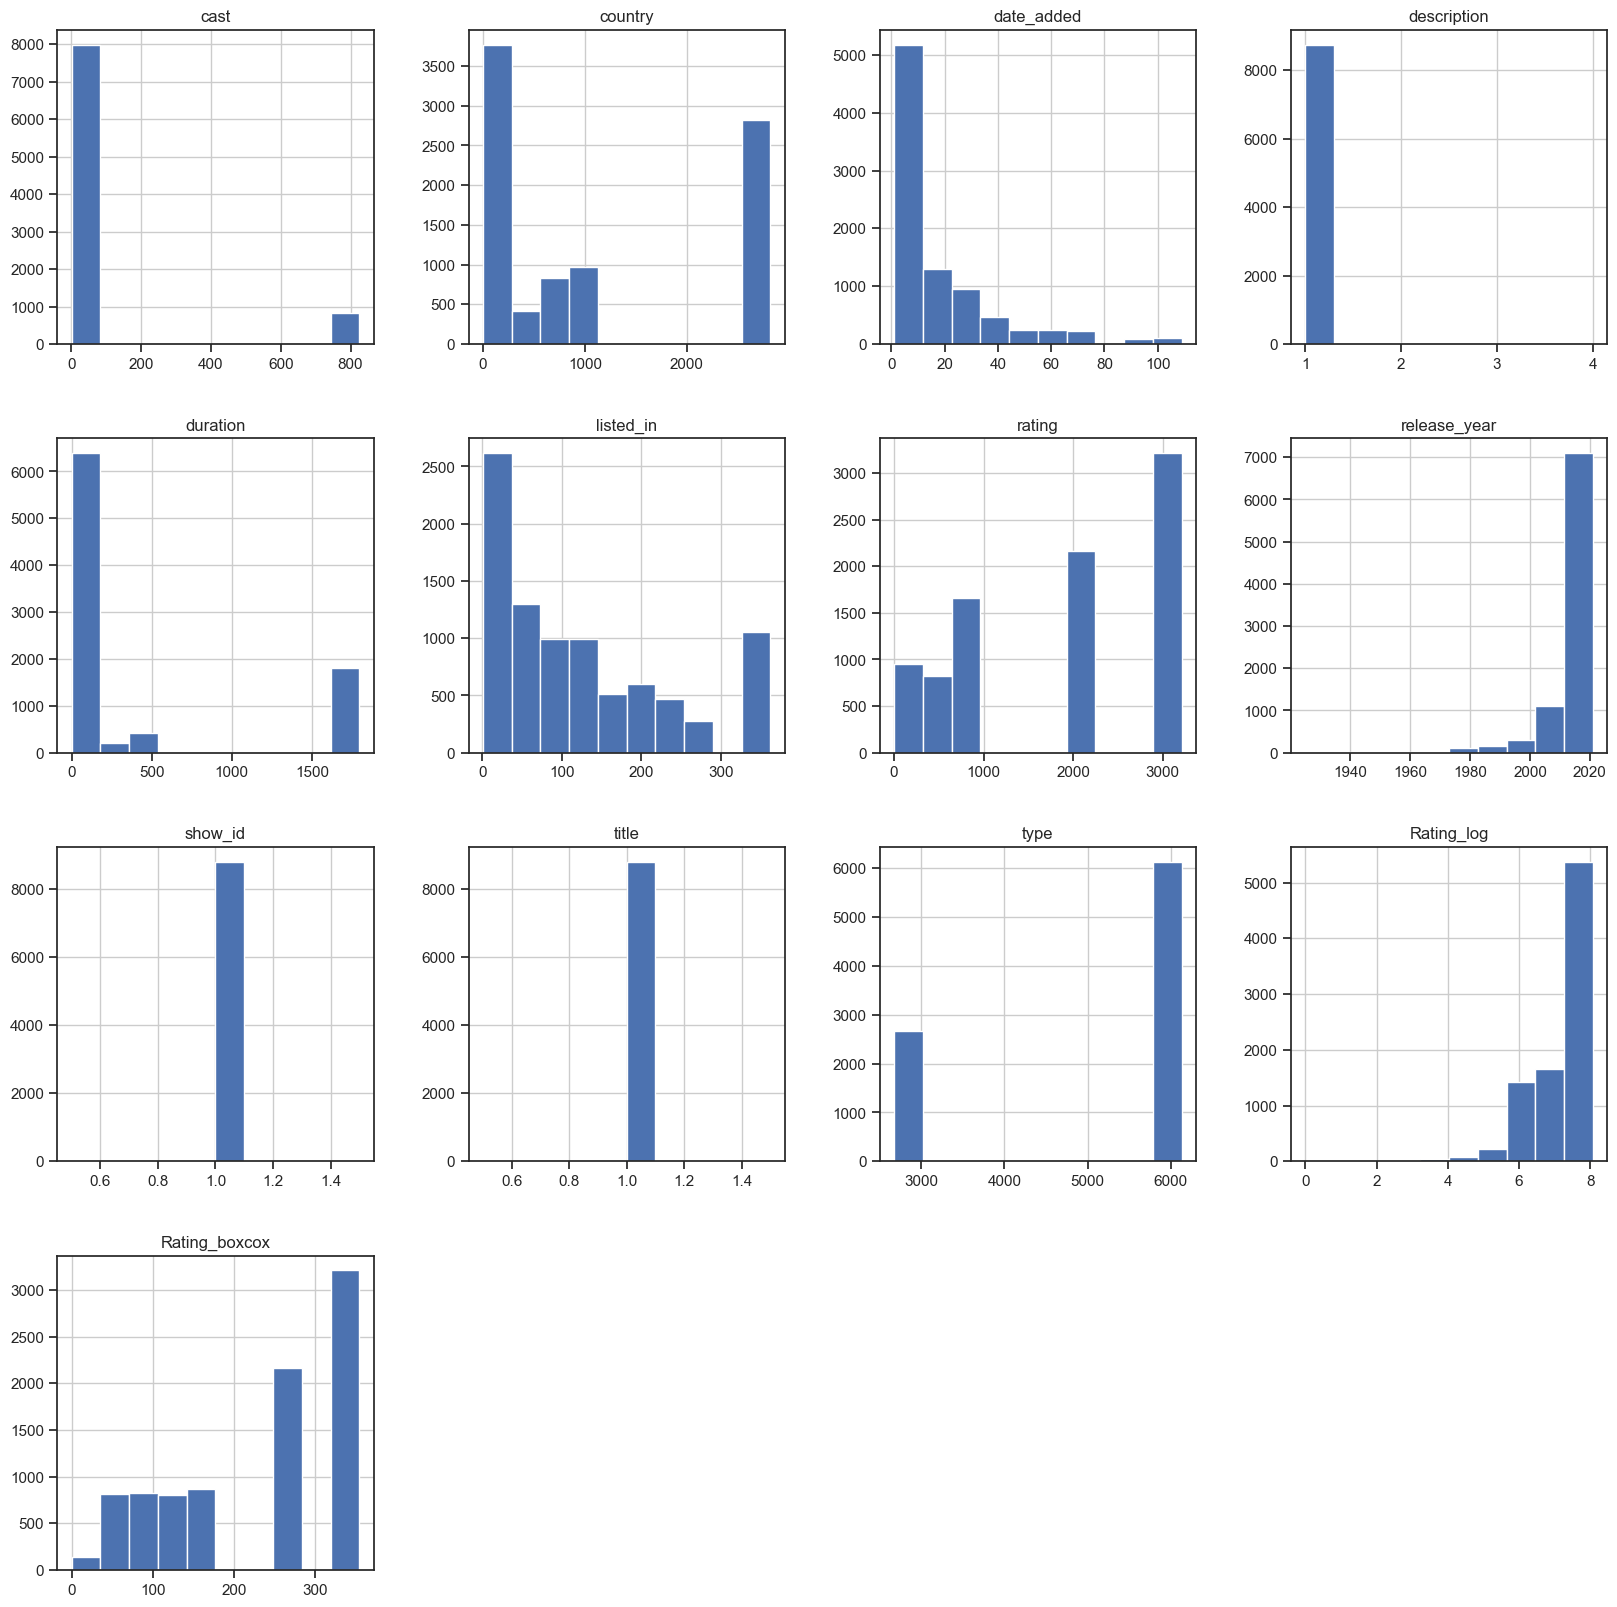

In [74]:
res.hist(figsize=(20,20))
plt.show()

In [65]:
res

,cast,country,date_added,description,duration,listed_in,rating,release_year,show_id,title,type
0,825,2818,1,1,152,359,490,2020,1,1,6131
1,1,30,10,1,425,26,3211,2021,1,1,2676
2,1,831,10,1,1796,18,3211,2021,1,1,2676
3,825,831,10,1,1796,16,3211,2021,1,1,2676
4,1,972,10,1,425,94,3211,2021,1,1,2676
...,...,...,...,...,...,...,...,...,...,...,...
8802,1,2818,30,1,12,1,799,2007,1,1,6131
8803,825,831,52,1,425,4,334,2018,1,1,2676
8804,1,2818,89,1,116,12,799,2009,1,1,6131
8805,1,2818,1,1,116,201,287,2006,1,1,6131


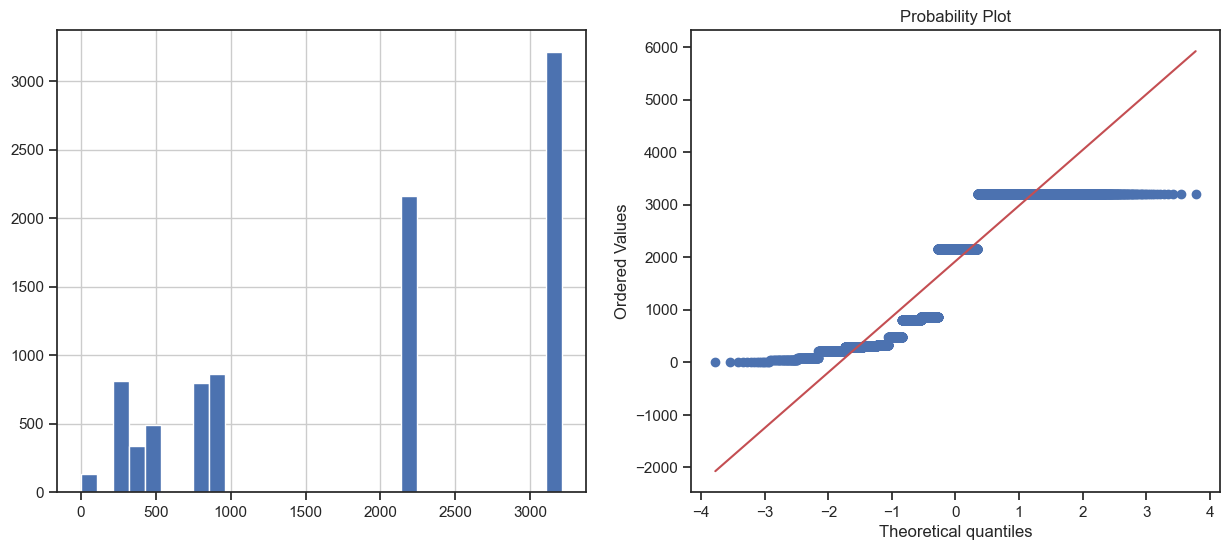

In [68]:
diagnostic_plots(res, 'rating')

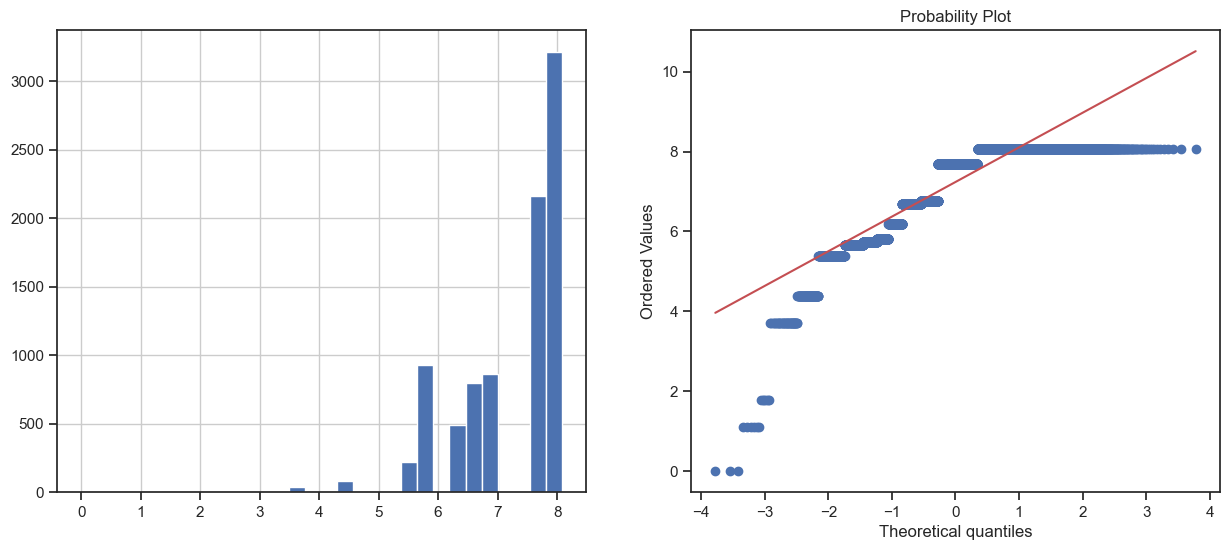

In [70]:
#  Логарифмическое преобразование
res['Rating_log'] = np.log(res['rating'])
diagnostic_plots(res, 'Rating_log')

Оптимальное значение λ = 0.6799528147632296


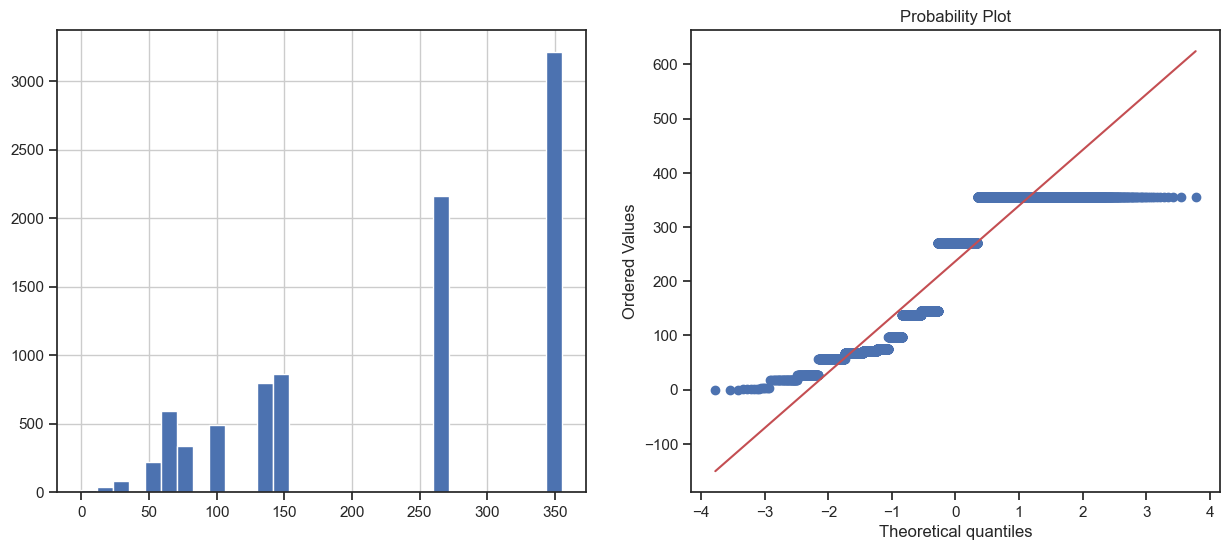

In [71]:
# Преобразование Бокса-Кокса
res['Rating_boxcox'], param = stats.boxcox(res['rating']) 
print('Оптимальное значение λ = {}'.format(param))
diagnostic_plots(res, 'Rating_boxcox')